# Compare MCMC with BBVI 

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys
import os

# Set path such that interpreter finds tigerpy
sys.path.append(os.path.join(os.getcwd(), ".."))

import liesel.goose as gs
import liesel.model as lsl
from liesel.distributions.mvn_degen import MultivariateNormalDegenerate as LieselMultivariateNormalDegenerate
from liesel.goose.types import Array

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate as TigerpyMultivariateNormalDegenerate

# Use distributions from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

In [2]:
import simulation.sim_fun.sim_data as sim_data

In [3]:
key = jax.random.PRNGKey(175380738)
data = sim_data.normal_complex_const(n_obs=1000, 
                                     key=key)

In [4]:
data["data"]

,loc,scale,x,y
0,4.102947,1.5,4.643378,5.767622
1,4.714541,1.5,-3.007162,7.427452
2,2.657943,1.5,2.225547,5.287754
3,4.594093,1.5,9.708319,5.525844
4,4.672566,1.5,9.623837,5.153082
...,...,...,...,...
995,3.849744,1.5,4.526799,4.775855
996,4.249774,1.5,1.564116,3.320481
997,4.682575,1.5,5.421648,2.982464
998,4.746173,1.5,1.003101,4.721336


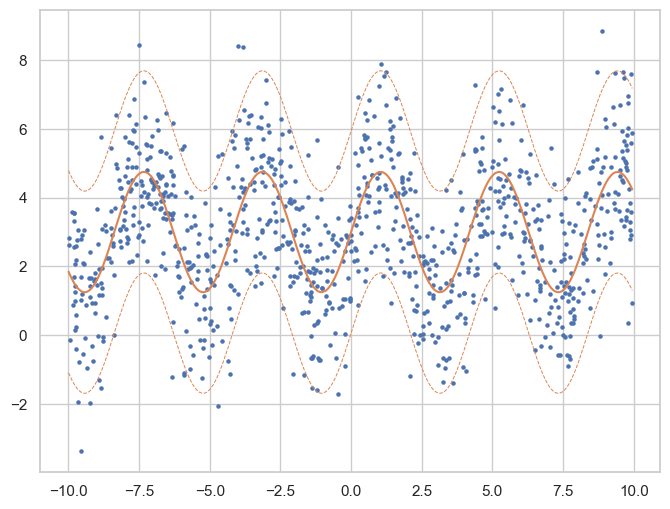

In [5]:
sim_data.plot_sim_data(data["data"], dist="normal")

## Fit from BBVI

In [6]:
# Preprocess data 
x = data["data"]["x"]
y = data["data"]["y"]

In [7]:
# Define a model with intercept 
# Set up design matrix 
X = tiger.Obs(name="X", intercept=True)
X.smooth(data=x)
# If we combine fixed covariates and smooth covariates we need to center the the smooth effects first 
X.center()

# Fixed coefficents 
# Set up beta_fixed hyperparameters 
beta_loc = tiger.Hyper(0.0, name="beta_loc")
beta_scale = tiger.Hyper(100.0, name="beta_scale")

# Set up parameters
beta_dist = tiger.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=0.0, distribution=beta_dist, name="beta")

# Smooth coefficients
# Set up hyperparameters for the beta_smooth_scale  
tau2_a = tiger.Hyper(1.0, name="tau2_a")
tau2_b = tiger.Hyper(0.00005, name="tau2_b")
tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=tau2_a, scale=tau2_b)
tau2 = tiger.Param(value=jnp.array([1.0]), distribution=tau2_dist, param_space="positive", name="tau2")

# Smooth coefficients
# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
gamma_loc = tiger.Hyper(jnp.zeros(X.smooth_dim_cent[0]), name="gamma_loc")

# Define the penalty matrix 
gamma_pen = tiger.Hyper(X.smooth_pen_mat_cent[0], name="gamma_pen")

# Set up parameters

# test what happens if I set loc to zero 
gamma_dist = tiger.Dist(TigerpyMultivariateNormalDegenerate, loc=gamma_loc, var=tau2, pen=gamma_pen)
gamma = tiger.Param(value=jnp.zeros(X.smooth_dim_cent[0]), distribution=gamma_dist, name="gamma")

# Set up the linear predictor
lpred = tiger.Lpred(obs=X, beta=beta, gamma=gamma)

# Set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=y.to_numpy(), distribution=response_dist)

In [8]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

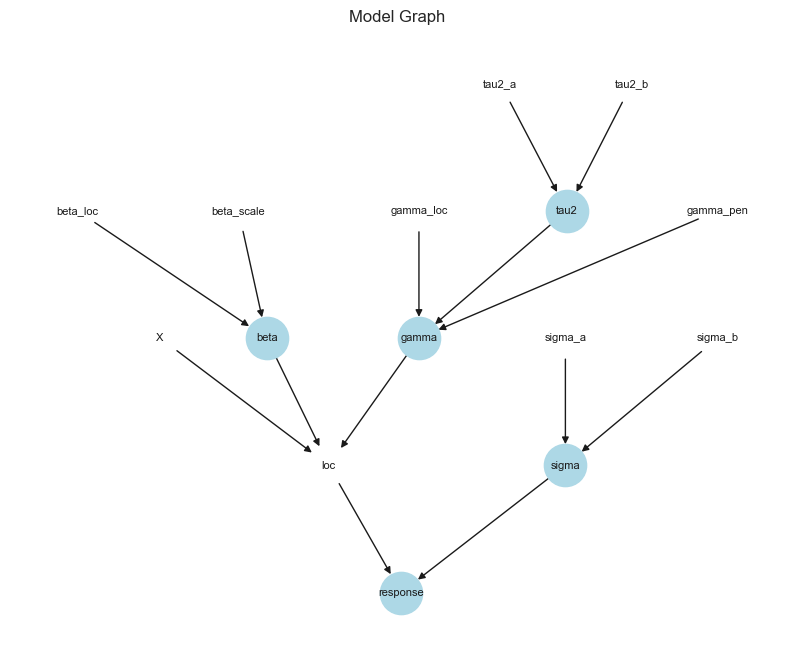

In [9]:
graph.visualize_graph()

In [10]:
q = bbvi.Bbvi(graph=graph, 
              pre_train=False)
key, subkey = jax.random.split(key)

In [11]:
q.run_bbvi(key=subkey,
           learning_rate=0.01,
           grad_clip=1,
           threshold=1e-2,
           batch_size=256,
           num_var_samples=64,
           chunk_size=50,
           epochs=500)

Start optimization ...
Finished optimization


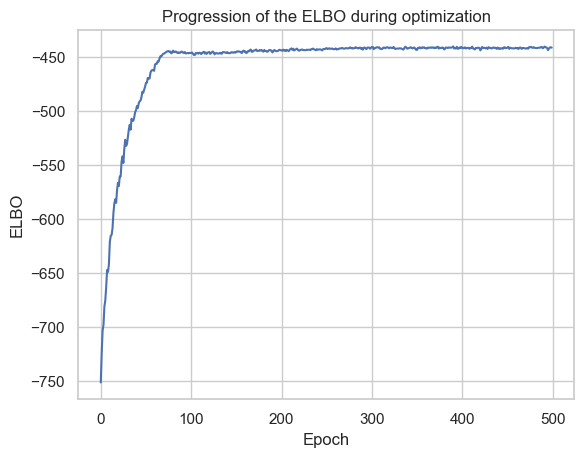

In [12]:
q.plot_elbo()

In [13]:
q.return_loc_params

{'beta': {'loc': Array([2.9560409], dtype=float32)},
 'tau2': {'loc': Array([6.6563735], dtype=float32)},
 'sigma': {'loc': Array([1.5226179], dtype=float32)},
 'gamma': {'loc': Array([ 1.6865095 ,  1.0381472 , -1.923774  , -1.5022854 ,  1.5644637 ,
          1.7422266 ,  0.19280422, -1.9452649 , -1.7392676 ,  1.2281498 ,
          2.3010201 , -0.76080483, -2.418071  , -1.3885984 ,  1.2629483 ,
          1.7060483 , -0.76947093, -1.1002651 , -0.7336218 ], dtype=float32)}}

In [14]:
beta = q.trans_var_params["beta"]["loc"]
gamma = q.trans_var_params["gamma"]["loc"]
loc_param = jnp.concatenate((beta, gamma))
y_opt = X.design_matrix @ loc_param

In [15]:
pred_data_tiger = pd.DataFrame({"x": x, "y":y_opt})
sort_pred_data_tiger = pred_data_tiger.sort_values("x")

In [16]:
sort_df = data["data"].sort_values("x")

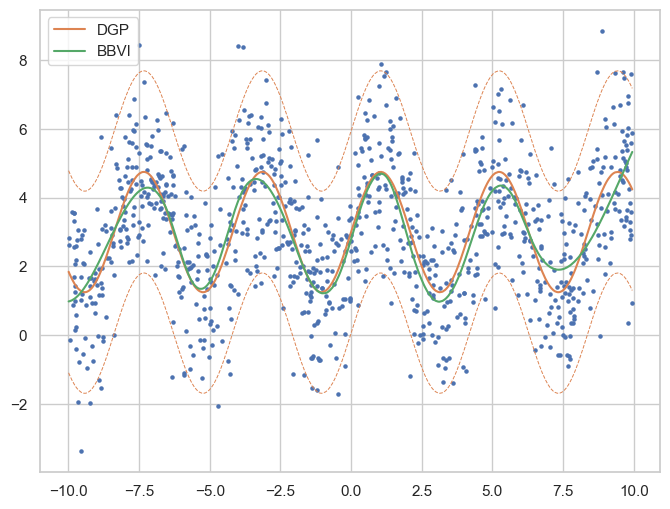

In [17]:
# plot the data
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

plt.scatter(x=sort_df["x"], y=sort_df["y"], s=5)
plt.plot(sort_df["x"], sort_df["loc"], label="DGP", color=sns.color_palette()[1])
plt.plot(sort_df["x"], sort_df["loc"] + 1.96*sort_df["scale"], linewidth=0.7, color=sns.color_palette()[1], linestyle='dashed')
plt.plot(sort_df["x"], sort_df["loc"] - 1.96*sort_df["scale"], linewidth=0.7, color=sns.color_palette()[1], linestyle='dashed')
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y"], color=sns.color_palette()[2], label = "BBVI")
plt.legend()
plt.show()

sns.reset_orig()

## Fit from liesel

In [18]:
# Define Groups for the smooth parameter priors
class VarianceIG(lsl.Group):
    def __init__(
        self, name: str, a: float, b: float, start_value: float = 1000.0
    ) -> None:
        a_var = lsl.Var(a, name=f"{name}_a")
        b_var = lsl.Var(b, name=f"{name}_b")

        prior = lsl.Dist(tfjd.InverseGamma, concentration=a_var, scale=b_var)
        tau2 = lsl.param(start_value, distribution=prior, name=name)
        super().__init__(name=name, a=a_var, b=b_var, tau2=tau2)

class SplineCoef(lsl.Group):
    def __init__(self, name: str, penalty: Array, tau2: lsl.param) -> None:
        penalty_var = lsl.Var(penalty, name=f"{name}_penalty")

        evals = jax.numpy.linalg.eigvalsh(penalty)
        rank = lsl.Data(jnp.sum(evals > 0.0), _name=f"{name}_rank")
        _log_pdet = jnp.log(jnp.where(evals > 0.0, evals, 1.0)).sum()
        log_pdet = lsl.Data(_log_pdet, _name=f"{name}_log_pdet")

        prior = lsl.Dist(
            LieselMultivariateNormalDegenerate.from_penalty,
            loc=0.0,
            var=tau2,
            pen=penalty_var,
            rank=rank,
            log_pdet=log_pdet
        )
        start_value = np.zeros(np.shape(penalty)[-1], np.float32)

        coef = lsl.param(start_value, distribution=prior, name=name)

        super().__init__(name, coef=coef, penalty=penalty_var, tau2=tau2, rank=rank)

class PSpline(lsl.Group):
    def __init__(
        self, name, basis_matrix: Array, penalty: Array, tau2_group: lsl.Group
    ) -> None:
        coef_group = SplineCoef(
            name=f"{name}_coef", penalty=penalty, tau2=tau2_group["tau2"]
        )

        basis_matrix = lsl.obs(basis_matrix, name="basis_matrix")
        smooth = lsl.Var(
            lsl.Calc(jnp.dot, basis_matrix, coef_group["coef"]), name=name
        )

        group_vars = coef_group.nodes_and_vars | tau2_group.nodes_and_vars

        super().__init__(
            name=name,
            basis_matrix=basis_matrix,
            smooth=smooth,
            **group_vars
        )

In [19]:
# Set up model in liesel
# Fixed parameter prior
beta_loc = lsl.Var(0.0, name="beta_loc")
beta_scale = lsl.Var(100.0, name="beta_scale")

# Set up the fixed parameters
beta_dist = lsl.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = lsl.param(value=np.array([0.0]), distribution=beta_dist, name="beta")

# Set up the smooth parameters
tau2_group = VarianceIG(name="tau2", a=1.0, b=0.00005)

penalty = X.smooth_pen_mat_cent[0]
smooth_group_1 = PSpline(name="smooth_1", basis_matrix=X.design_mat_cent[1], penalty=penalty, tau2_group=tau2_group)

# Set up the scale 
sigma_a = lsl.Var(0.01, name="sigma_a")
sigma_b = lsl.Var(0.01, name="sigma_b")

sigma_dist = lsl.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = lsl.param(value=10.0, distribution=sigma_dist, name="sigma")

Z = lsl.obs(X.fixed_data, name="Z")

lpred_loc_fn = lambda z, beta, smooth_1: jnp.dot(z, beta) + smooth_1
lpred_loc_calc = lsl.Calc(lpred_loc_fn, z=Z, beta=beta, smooth_1=smooth_group_1["smooth"])

lpred_loc = lsl.Var(lpred_loc_calc, name="lpred_loc")

response_dist = lsl.Dist(tfjd.Normal, loc=lpred_loc, scale=sigma)
response = lsl.Var(y.to_numpy(), distribution=response_dist, name="response")

In [20]:
gb = lsl.GraphBuilder().add(response)
gb.transform(sigma, tfjb.Exp)

liesel.model.model - INFO - Converted dtype of Data(name="smooth_1_coef_penalty_value").value
liesel.model.model - INFO - Converted dtype of Data(name="beta_value").value
liesel.model.model - INFO - Converted dtype of Data(name="Z_value").value


Var(name="sigma_transformed")

In [21]:
model = gb.build_model()

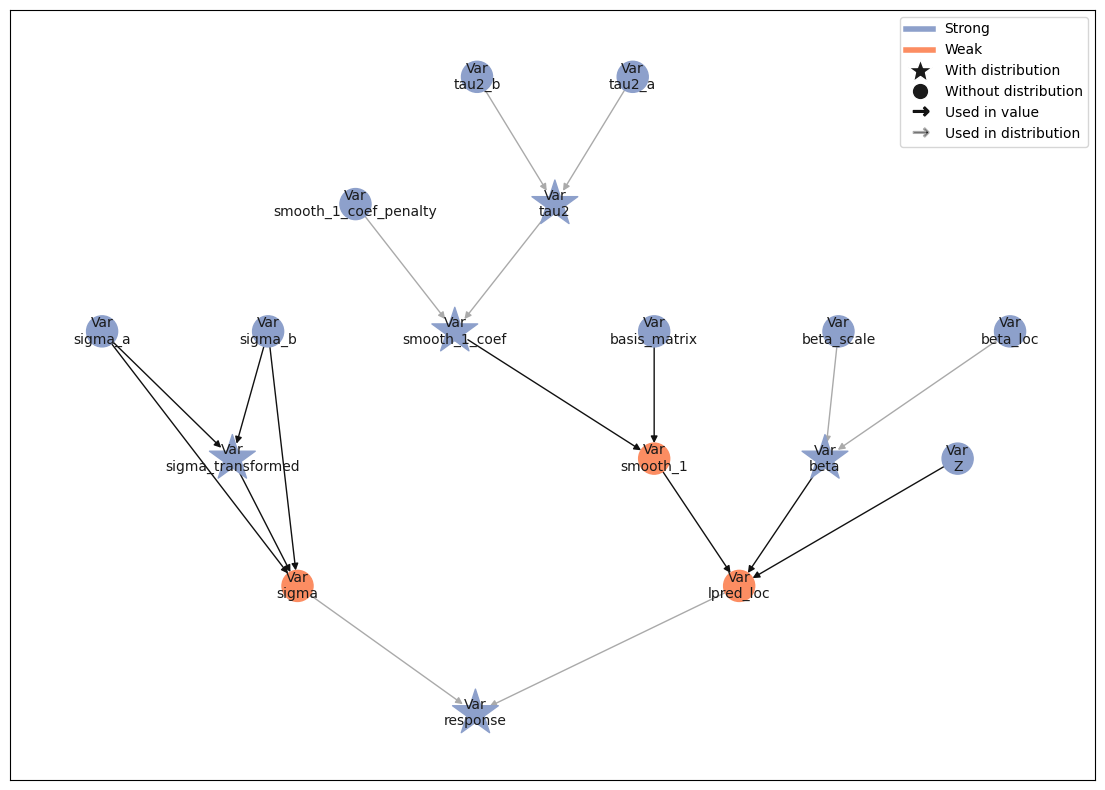

In [22]:
lsl.plot_vars(model)

In [23]:
def tau2_gibbs_kernel(p_spline: PSpline) -> gs.GibbsKernel:
    """Builds a Gibbs kernel for a smoothing parameter with an inverse gamma prior."""
    position_key = p_spline["tau2"].name

    def transition(prng_key, model_state):
        a_prior = p_spline.value_from(model_state, "a")
        b_prior = p_spline.value_from(model_state, "b")

        rank = p_spline.value_from(model_state, "rank")
        K = p_spline.value_from(model_state, "penalty")

        beta = p_spline.value_from(model_state, "coef")

        a_gibbs = jnp.squeeze(a_prior + 0.5 * rank)
        b_gibbs = jnp.squeeze(b_prior + 0.5 * (beta @ K @ beta))

        draw = b_gibbs / jax.random.gamma(prng_key, a_gibbs)

        return {position_key: draw}

    return gs.GibbsKernel([position_key], transition)

In [24]:
key, subkey = jax.random.split(key)
builder = gs.EngineBuilder(seed=subkey, num_chains=4)

builder.set_model(gs.LieselInterface(model))
builder.set_initial_values(model.state)

builder.add_kernel(tau2_gibbs_kernel(smooth_group_1))
builder.add_kernel(gs.NUTSKernel(["smooth_1_coef"]))
builder.add_kernel(gs.NUTSKernel(["beta"]))
builder.add_kernel(gs.NUTSKernel(["sigma_transformed"]))

builder.set_duration(warmup_duration=1000, posterior_duration=1000)

builder.positions_included = ["sigma"]

engine = builder.build()

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done


In [25]:
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together


liesel.goose.engine - WARNING - Errors per chain for kernel_01: 6, 12, 7, 10 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 3, 5, 2, 3 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 2, 2, 3, 3 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 3, 4, 4, 5 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 1, 1, 1, 1 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 2, 1, 1, 1 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 6, 7, 5, 9 / 50 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 1, 1, 1,

In [26]:
results = engine.get_results()
gs.Summary(results)

Parameter summary:

                            kernel      mean        sd    q_0.05     q_0.5  \
parameter         index                                                      
beta              (0,)   kernel_02  2.983650  0.048291  2.904130  2.983786   
sigma             ()             -  1.536150  0.034213  1.481214  1.535561   
sigma_transformed ()     kernel_03  0.429032  0.022258  0.392862  0.428896   
smooth_1_coef     (0,)   kernel_01  1.889048  0.198726  1.562647  1.892296   
                  (1,)   kernel_01  1.606017  0.222909  1.235085  1.606368   
                  (2,)   kernel_01 -2.208720  0.350087 -2.783940 -2.203704   
                  (3,)   kernel_01 -1.588332  0.405729 -2.259578 -1.584184   
                  (4,)   kernel_01  1.348079  0.376248  0.719887  1.345864   
                  (5,)   kernel_01  1.685120  0.394557  1.018001  1.688138   
                  (6,)   kernel_01  0.380547  0.393885 -0.265366  0.378753   
                  (7,)   kernel_01 -1.990729  0.369318 -2.601649 -1.994067   
                  (8,)   kernel_01 -1.810815  0.418030 -2.496377 -1.810751   
                  (9,)   kernel_01  1.354831  0.381393  0.722939  1.354253   
                  (10,)  kernel_01  2.389466  0.385117  1.740560  2.389732   
                  (11,)  kernel_01 -0.554767  0.378679 -1.178672 -0.560851   
                  (12,)  kernel_01 -2.458141  0.421101 -3.140828 -2.460429   
                  (13,)  kernel_01 -1.217355  0.425688 -1.919041 -1.209983   
                  (14,)  kernel_01  1.103473  0.395130  0.460919  1.107361   
                  (15,)  kernel_01  2.130999  0.364703  1.534372  2.125705   
                  (16,)  kernel_01 -1.383872  0.227350 -1.765169 -1.386256   
                  (17,)  kernel_01 -1.676122  0.200740 -2.002736 -1.677077   
                  (18,)  kernel_01 -0.426395  0.202174 -0.757427 -0.425678   
tau2              ()     kernel_00  8.636193  3.393323  4.700139  7.950782   

                            q_0.95  sample_size     ess_bulk     ess_tail  \
parameter         index                                                     
beta              (0,)    3.063590         4000  1544.528509  2080.581026   
sigma             ()      1.593662         4000  1348.284733  1967.043715   
sigma_transformed ()      0.466034         4000  1348.284843  1967.043715   
smooth_1_coef     (0,)    2.214429         4000  2687.823357  2545.554433   
                  (1,)    1.973652         4000  3651.490809  2646.504191   
                  (2,)   -1.634722         4000  3053.031007  2924.137583   
                  (3,)   -0.937536         4000  3481.946199  3342.856521   
                  (4,)    1.967030         4000  2922.080132  3101.482840   
                  (5,)    2.329776         4000  3290.983338  3139.345263   
                  (6,)    1.032566         4000  3054.455466  3008.434832   
                  (7,)   -1.378092         4000  3175.536788  2848.484740   
                  (8,)   -1.113555         4000  3315.290906  2528.157057   
                  (9,)    1.987270         4000  3346.845469  2788.399235   
                  (10,)   3.033373         4000  3189.769901  2812.455582   
                  (11,)   0.072911         4000  2932.402891  3071.403329   
                  (12,)  -1.751176         4000  2949.174056  2820.949670   
                  (13,)  -0.508687         4000  3252.205600  3033.620094   
                  (14,)   1.756583         4000  3165.375715  2875.346894   
                  (15,)   2.742514         4000  3096.498935  2639.091782   
                  (16,)  -1.011583         4000  3220.421870  2897.460372   
                  (17,)  -1.341192         4000  2596.903637  3001.259156   
                  (18,)  -0.103263         4000  3909.271473  3193.433309   
tau2              ()     14.908166         4000  2536.424460  3338.172921   

                             rhat  
parameter         index            
beta              (0,)   1.0007

/Users/SebLorek/anaconda3/envs/thesis/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/SebLorek/anaconda3/envs/thesis/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


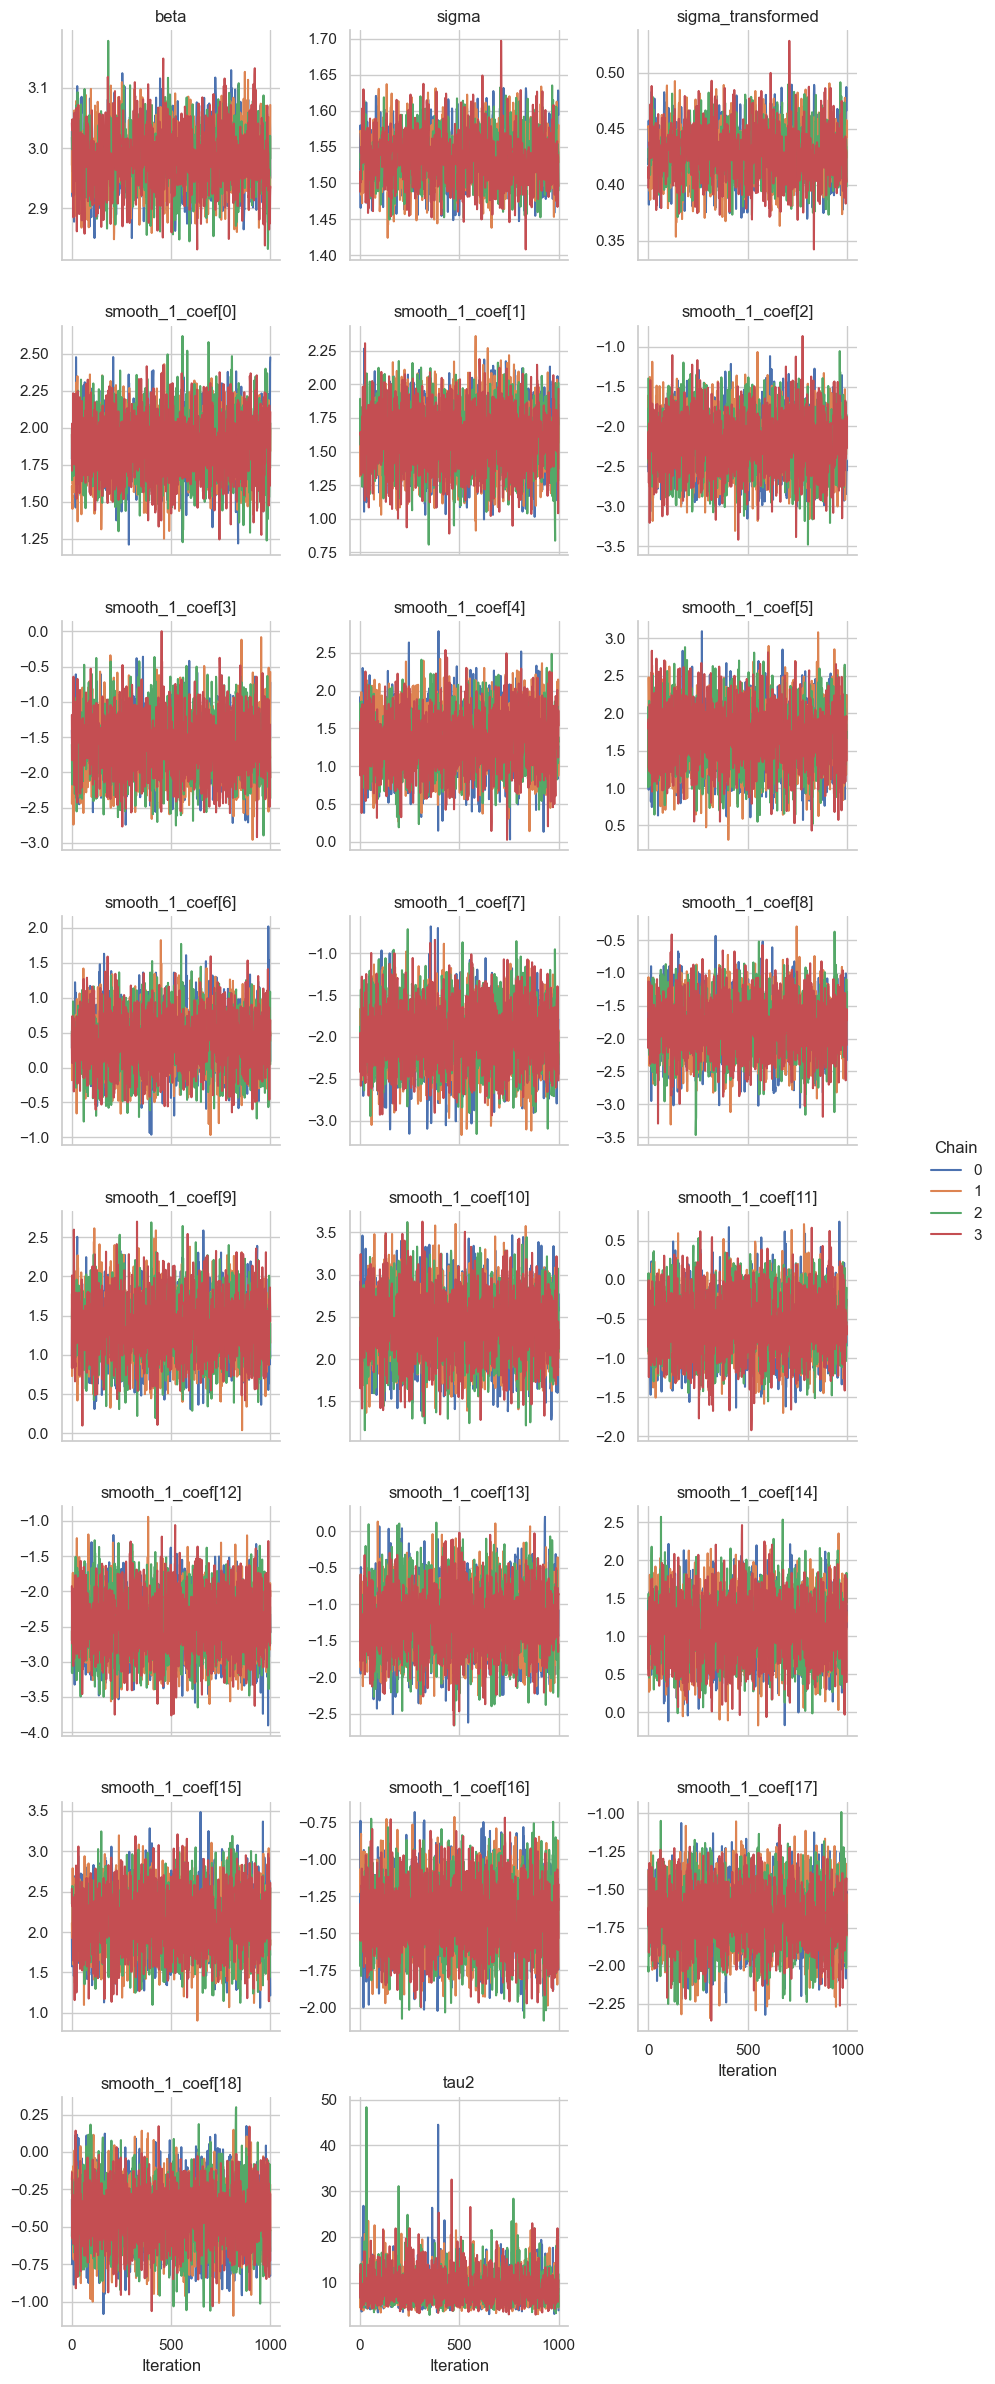

In [27]:
g = gs.plot_trace(results)

In [28]:
p = gs.Summary(results).quantities

In [29]:
p["mean"]

{'beta': array([2.9836504], dtype=float32),
 'sigma': array(1.5361501, dtype=float32),
 'sigma_transformed': array(0.4290316, dtype=float32),
 'smooth_1_coef': array([ 1.8890476 ,  1.6060169 , -2.20872   , -1.5883323 ,  1.348079  ,
         1.6851201 ,  0.38054714, -1.9907293 , -1.8108149 ,  1.3548313 ,
         2.389466  , -0.5547675 , -2.458141  , -1.2173551 ,  1.1034732 ,
         2.1309988 , -1.3838722 , -1.6761223 , -0.4263954 ], dtype=float32),
 'tau2': array(8.636193, dtype=float32)}

In [30]:
q.return_loc_params

{'beta': {'loc': Array([2.9560409], dtype=float32)},
 'tau2': {'loc': Array([6.6563735], dtype=float32)},
 'sigma': {'loc': Array([1.5226179], dtype=float32)},
 'gamma': {'loc': Array([ 1.6865095 ,  1.0381472 , -1.923774  , -1.5022854 ,  1.5644637 ,
          1.7422266 ,  0.19280422, -1.9452649 , -1.7392676 ,  1.2281498 ,
          2.3010201 , -0.76080483, -2.418071  , -1.3885984 ,  1.2629483 ,
          1.7060483 , -0.76947093, -1.1002651 , -0.7336218 ], dtype=float32)}}

In [31]:
q.get_posterior_samples(sample_shape=1000)

{'beta': Array([[2.952455 ],
        [2.8939946],
        [2.929762 ],
        [2.9439454],
        [2.962926 ],
        [2.9534502],
        [3.0275865],
        [3.0121565],
        [3.0357897],
        [3.0425057],
        [2.997172 ],
        [2.9767632],
        [2.9897888],
        [2.9719663],
        [2.7904317],
        [2.9560957],
        [2.9619372],
        [2.9529529],
        [2.9491775],
        [2.9657295],
        [2.9628263],
        [2.9727385],
        [2.9532578],
        [2.8990295],
        [3.0126135],
        [2.9813542],
        [2.8869681],
        [2.9910522],
        [2.989392 ],
        [2.9835227],
        [2.9121385],
        [3.0661583],
        [2.9740248],
        [2.9359734],
        [2.9416873],
        [2.9434242],
        [2.9433928],
        [2.9484158],
        [2.918683 ],
        [3.0868466],
        [2.9372418],
        [2.9211094],
        [2.9598243],
        [2.945639 ],
        [2.9794343],
        [2.9856076],
        [2.9550118],
     

In [32]:
post_samples = results.get_posterior_samples()

## Comparison 

In [32]:
b_fixed = p["mean"]["beta"]
b_smooth = p["mean"]["smooth_1_coef"]
b = jnp.concatenate((b_fixed, b_smooth))
y_opt = X.design_matrix @ b

In [33]:
pred_data_lsl = pd.DataFrame({"x": x, "y":y_opt})
sort_pred_data_lsl = pred_data_lsl.sort_values("x")

In [34]:
jnp.mean(sort_pred_data_tiger["y"].to_numpy()- sort_pred_data_lsl["y"].to_numpy())

Array(-0.00646593, dtype=float32)

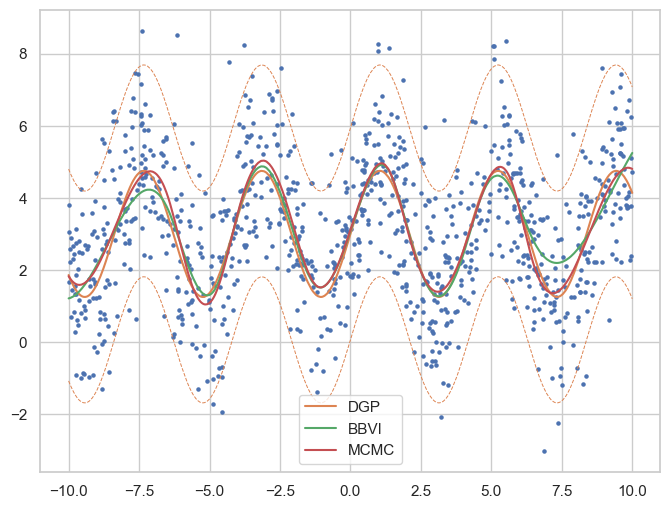

In [35]:
# plot the data
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

plt.scatter(x=sort_df["x"], y=sort_df["y"], s=5)
plt.plot(sort_df["x"], sort_df["loc"], label="DGP", color=sns.color_palette()[1])
plt.plot(sort_df["x"], sort_df["loc"] + 1.96*sort_df["scale"], linewidth=0.7, color=sns.color_palette()[1], linestyle='dashed')
plt.plot(sort_df["x"], sort_df["loc"] - 1.96*sort_df["scale"], linewidth=0.7, color=sns.color_palette()[1], linestyle='dashed')
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y"], color=sns.color_palette()[2], label = "BBVI")
plt.plot(sort_pred_data_lsl["x"], sort_pred_data_lsl["y"], color=sns.color_palette()[3], label = "MCMC")
plt.legend()
plt.show()

sns.reset_orig()